In [10]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os

def extract_axis(header, axis=1):
    n_elements = header['NAXIS{}'.format(axis)]
    crpix = header['CRPIX{}'.format(axis)]
    crval = header['CRVAL{}'.format(axis)]
    cdelt = header['CDELT{}'.format(axis)]

    i = 1 + np.arange(n_elements)
    return crval + cdelt * (i - crpix)


### Choose your grating_filter between 'g140m_f100lp' and 'g235m_f170lp'
grating_filter = 'g140m_f100lp' 


### Insert the path of your cube
cube_path = './data/RM312_jw2057_px0.05_dr_CTX1364_v1.18.1_g140m-f100lp_OD_98.5_skyalign_cgs_s3d.fits' 



### Opening the cube
hdu = fits.open(cube_path)
cube = hdu[1].data 
wl = extract_axis(hdu['SCI'].header, axis=3)
hdul_save = fits.HDUList([hdu_.copy() for hdu_ in hdu])

nz, ny, nx = cube.shape

In [11]:
if grating_filter == 'g140m_f100lp':
    hdul = fits.open("./calibration_files/calibration_functions_g140m_f100lp.fits")
    data = hdul[1].data
    
if grating_filter == 'g235m_f170lp':
    hdul = fits.open("./calibration_files/calibration_functions_g235m_f170lp.fits")
    data = hdul[1].data    

### Open the file
wavelength = data["wavelength"]
k  = data["k"]
alpha  = data["alpha"]
beta = data["beta"]
hdul.close()



In [12]:
def find_nearest_indices(target_wl, wl_array):
    diff = np.abs(wl_array[:, None] - target_wl[None, :])
    return diff.argmin(axis=0)


#Find index corresponding to lambda/2 and lambda/3

index_lambda_2 = find_nearest_indices(wl/2, wl)
index_lambda_3 = find_nearest_indices(wl/3, wl)

cube_half = cube[index_lambda_2, :, :]  
cube_third = cube[index_lambda_3, :, :] 


# Apply flux calibration
cube_calibrated = (cube - alpha[:, None, None] * cube_half
                         - beta[:, None, None] * cube_third) / k[:, None, None]

In [13]:
hdul_save[1].data = cube_calibrated

In [14]:

## Save the calibrated cube

base, ext = os.path.splitext(cube_path)
path_save = base + "_calibrated" + ext
hdul_save.writeto(path_save, overwrite=True)

# Close all file
hdu.close()
hdul_save.close()

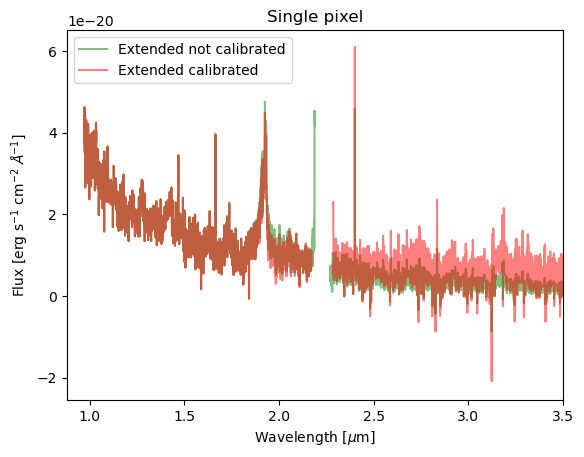

In [20]:
plt.title('Single pixel')
plt.plot(wl, cube[:, int(ny/2), int(nx/2)], alpha=0.5, label='Extended not calibrated', color='green')
plt.plot(wl, cube_calibrated[:, int(ny/2), int(nx/2)], alpha=0.5, color='red', label='Extended calibrated')
plt.xlim(0.88, 3.5)
plt.xlabel(r'Wavelength [$\mu$m]')
plt.ylabel(r'Flux [erg s$^{-1}$ cm$^{-2}$ $\AA$$^{-1}$]')

plt.legend()

plt.show()